The following is a progressively scaled benchmarking of two primary things:
- pandas' `pd.read_csv()` function VS `feather-format`
- `.apply` & `lambda` functions VS pandas built-ins for `datetime` conversion

The results were computed on AWS SageMaker - an ml.m5.4xlarge instance or larger as the unzipped data file size grew.  

TL;DR:
- Importing with `feather-format` was generally >2x faster than pandas' `pd.read_csv()`
- Using pandas built-ins was generally 30-50x faster (serious efficiency gains)

this install pyarrow - a necessary dependency for feather-format

In [1]:
pip install pyarrow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install feather-format

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import json
import gzip
from urllib.request import urlopen
import feather 

## Magazine data (~89k reviews)

In [4]:
# download the data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Magazine_Subscriptions.json.gz

### load the meta data
data = []
with gzip.open('Magazine_Subscriptions.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
# convert list into pandas dataframe
df_magazines = pd.DataFrame.from_dict(data)

--2020-09-16 00:11:28--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Magazine_Subscriptions.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12875273 (12M) [application/octet-stream]
Saving to: ‘Magazine_Subscriptions.json.gz’

Magazine_Subscripti 100%[===================>]  12.28M  13.0MB/s    in 0.9s    

2020-09-16 00:11:29 (13.0 MB/s) - ‘Magazine_Subscriptions.json.gz’ saved [12875273/12875273]



Sum up the null columns

Drop the unneeded columns

Save the data as a csv & feather format

In [5]:
# check for columns with nulls
df_magazines.isnull().sum()

overall               0
vote              65586
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          2
reviewText           33
summary              19
unixReviewTime        0
style             38291
image             89554
dtype: int64

In [6]:
# drop columns containing nulls
df_magazines = df_magazines.drop(columns=['vote', 'reviewTime', 'asin', 'reviewerID', 'image', 'verified', 'style'])

#print current shapes
print(df_magazines.shape)

# saving the dataframe 
df_magazines.to_csv('Magazine_Subscriptions.csv')

# save in feather format
df_magazines.to_feather('Magazine_Subscriptions.feather')

(89689, 5)


Read in the csv as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [11]:
startTime = time.time()

#load csvs
df_magazines = pd.read_csv('Magazine_Subscriptions.csv')

#print current shape
print(df_magazines.shape)

# print time & save time for later comparison
time_csv_1 = time.time() - startTime
print(f'Time: {time_csv_1:.2f}')

(89689, 6)
Time: 0.30


Transform the date column using `.apply` and a `lambda` function - time it

Save time as a variable for later usage/comparison

In [12]:
df_magazines.columns
print(df_magazines.shape)

(89689, 6)


In [13]:
startTime = time.time()

# converting 'reviewTime' to pandas datetime
df_magazines['datetime'] = pd.to_datetime(df_magazines['unixReviewTime'], unit='s')

# created sep column for 'Year' 
df_magazines['Year'] = df_magazines['datetime'].apply(lambda x: "%d" % (x.year))
# created sep column for 'Year' 
df_magazines['Month'] = df_magazines['datetime'].apply(lambda x: "%d" % (x.month))

# print shape to confirm
print(df_magazines.shape)

# print time & save time for later comparison
time_csv_2 = time.time() - startTime
print(f'Time: {time_csv_2:.2f}')

(89689, 9)
Time: 0.68


Read in the `.feather` file as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [14]:
startTime = time.time()

# read in feather format
df_magazines = feather.read_dataframe('Magazine_Subscriptions.feather')

#print current shape to confirm
print(df_magazines.shape)

# print time & save time for later comparison
time_feather_1 = time.time() - startTime
print(f'Time: {time_feather_1:.2f}')

(89689, 5)
Time: 0.11


Using built in unix -> datetime conversion and pull out years/month to separate columsn ([stackoverflow](https://stackoverflow.com/questions/62292464/how-do-i-add-a-year-and-month-columns-to-my-pandas-dataframe-using-unix-timestam))
- time it

Save time as a variable for later usage/comparison

In [15]:
startTime = time.time()

#Convert unix timestamps to datetime.
df_magazines['datetime'] = pd.to_datetime(df_magazines['unixReviewTime'],unit='s')

#Set the 'datetime' field to be the index.
df_magazines.set_index('datetime',inplace=True)

#Extract the month from the index.
df_magazines['Month'] = df_magazines.index.month

#Extract the year from the index.
df_magazines['Year'] = df_magazines.index.year

# note that that the shape will have one less bc the 'datetime' as the index isn't counted
print(df_magazines.shape)

time_feather_2 = time.time() - startTime
print(f'Time: {time_feather_2:.2f}')

(89689, 7)
Time: 0.02


Time comparison of 

1) `csv` VS `feather` files

2) `.apply` & `lambda` VS native pandas conversions

In [16]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')
print('---------------------------------------')
print(f'CSV load time: {time_csv_1}')
print(f'Feather load time: {time_feather_1}')

print(f'CSV datetime conversion & creation: {time_csv_2}')
print(f'Feather datetime conversion & creation: {time_feather_2}')

TL:DR
Import was 2.84x faster with feather
Conversion was 32.17x faster with built-ins VS .apply and lambda
---------------------------------------
CSV load time: 0.30130887031555176
Feather load time: 0.10614585876464844
CSV datetime conversion & creation: 0.6788976192474365
Feather datetime conversion & creation: 0.021103858947753906


In [17]:
# remove current files
os.remove('Magazine_Subscriptions.json.gz')
os.remove('Magazine_Subscriptions.feather')
os.remove('Magazine_Subscriptions.csv')

## Fashion data (~883k reviews)

In [18]:
# download the data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz

### load the meta data
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
# convert list into pandas dataframe
df_fashion = pd.DataFrame.from_dict(data)

--2020-09-15 22:17:06--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/octet-stream]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  23.7MB/s    in 4.1s    

2020-09-15 22:17:11 (21.6 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]



Sum up the null columns

Drop the unneeded columns

Save the data as a csv & feather format

In [19]:
# check for columns with nulls
df_fashion.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          92
reviewText          1233
summary              533
unixReviewTime         0
vote              803736
style             579067
image             854829
dtype: int64

In [20]:
# drop columns containing nulls
df_fashion = df_fashion.drop(columns=['vote', 'reviewTime', 'asin', 'reviewerID', 'image', 'verified', 'style'])

#print current shapes
print(df_fashion.shape)

# saving the dataframe 
df_fashion.to_csv('AMAZON_FASHION.csv')

# save in feather format
df_fashion.to_feather('AMAZON_FASHION.feather')

(883636, 5)


Read in the csv as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [21]:
startTime = time.time()

#load csvs
df_fashion = pd.read_csv('AMAZON_FASHION.csv')

#print current shape
print(df_fashion.shape)

# print time & save time for later comparison
time_csv_1 = time.time() - startTime
print(f'Time: {time_csv_1:.2f}')

(883636, 6)
Time: 2.28


Transform the date column using `.apply` and a `lambda` function - time it

Save time as a variable for later usage/comparison

In [22]:
df_fashion.columns
print(df_fashion.shape)

(883636, 6)


In [23]:
startTime = time.time()

# converting 'reviewTime' to pandas datetime
df_fashion['datetime'] = pd.to_datetime(df_fashion['unixReviewTime'], unit='s')

# created sep column for 'Year' 
df_fashion['Year'] = df_fashion['datetime'].apply(lambda x: "%d" % (x.year))
# created sep column for 'Year' 
df_fashion['Month'] = df_fashion['datetime'].apply(lambda x: "%d" % (x.month))

# print shape to confirm
print(df_fashion.shape)

# print time & save time for later comparison
time_csv_2 = time.time() - startTime
print(f'Time: {time_csv_2:.2f}')

(883636, 9)
Time: 7.78


Read in the `.feather` file as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [24]:
startTime = time.time()

# read in feather format
df_fashion = feather.read_dataframe('AMAZON_FASHION.feather')

#print current shape to confirm
print(df_fashion.shape)

# print time & save time for later comparison
time_feather_1 = time.time() - startTime
print(f'Time: {time_feather_1:.2f}')

(883636, 5)
Time: 0.95


Using built in unix -> datetime conversion and pull out years/month to separate columsn ([stackoverflow](https://stackoverflow.com/questions/62292464/how-do-i-add-a-year-and-month-columns-to-my-pandas-dataframe-using-unix-timestam))
- time it

Save time as a variable for later usage/comparison

In [25]:
startTime = time.time()

#Convert unix timestamps to datetime.
df_fashion['datetime'] = pd.to_datetime(df_fashion['unixReviewTime'],unit='s')

#Set the 'datetime' field to be the index.
df_fashion.set_index('datetime',inplace=True)

#Extract the month from the index.
df_fashion['Month'] = df_fashion.index.month

#Extract the year from the index.
df_fashion['Year'] = df_fashion.index.year

# note that that the shape will have one less bc the 'datetime' as the index isn't counted
print(df_fashion.shape)

time_feather_2 = time.time() - startTime
print(f'Time: {time_feather_2:.2f}')

(883636, 7)
Time: 0.18


Time comparison of 

1) `csv` VS `feather` files

2) `.apply` & `lambda` VS native pandas conversions

In [26]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')
print('---------------------------------------')
print(f'CSV load time: {time_csv_1}')
print(f'Feather load time: {time_feather_1}')

print(f'CSV datetime conversion & creation: {time_csv_2}')
print(f'Feather datetime conversion & creation: {time_feather_2}')

TL:DR
Import was 2.40x faster with feather
Conversion was 43.47x faster with built-ins VS .apply and lambda
---------------------------------------
CSV load time: 2.2843637466430664
Feather load time: 0.9531755447387695
CSV datetime conversion & creation: 7.775021314620972
Feather datetime conversion & creation: 0.1788463592529297


In [27]:
# remove created files
os.remove('AMAZON_FASHION.csv')
os.remove('AMAZON_FASHION.feather')
os.remove('AMAZON_FASHION.json.gz')

## Office Products data (~5.5M reviews)

In [28]:
# download the data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Office_Products.json.gz

### load the meta data
data = []
with gzip.open('Office_Products.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
# convert list into pandas dataframe
df_office = pd.DataFrame.from_dict(data)

--2020-09-15 22:19:30--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Office_Products.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698526945 (666M) [application/octet-stream]
Saving to: ‘Office_Products.json.gz’

Office_Products.jso 100%[===================>] 666.17M  22.1MB/s    in 30s     

2020-09-15 22:20:01 (21.9 MB/s) - ‘Office_Products.json.gz’ saved [698526945/698526945]



Sum up the null columns

Drop the unneeded columns

Save the data as a csv & feather format

In [29]:
# check for columns with nulls
df_office.isnull().sum()

overall                 0
vote              4954740
verified                0
reviewTime              0
reviewerID              0
asin                    0
style             2747821
reviewerName          428
reviewText           2830
summary              1305
unixReviewTime          0
image             5486173
dtype: int64

In [30]:
# drop columns containing nulls
df_office = df_office.drop(columns=['vote', 'reviewTime', 'asin', 'reviewerID', 'image', 'verified', 'style'])

#print current shapes
print(df_office.shape)

# saving the dataframe 
df_office.to_csv('Office_Products.csv')

# save in feather format
df_office.to_feather('Office_Products.feather')

(5581313, 5)


Read in the csv as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [31]:
startTime = time.time()

#load csvs
df_office = pd.read_csv('Office_Products.csv')

#print current shape
print(df_office.shape)

# print time & save time for later comparison
time_csv_1 = time.time() - startTime
print(f'Time: {time_csv_1:.2f}')

(5581313, 6)
Time: 16.85


Transform the date column using `.apply` and a `lambda` function - time it

Save time as a variable for later usage/comparison

In [33]:
df_office.columns
print(df_office.shape)

(5581313, 6)


In [34]:
startTime = time.time()

# converting 'reviewTime' to pandas datetime
df_office['datetime'] = pd.to_datetime(df_office['unixReviewTime'], unit='s')

# created sep column for 'Year' 
df_office['Year'] = df_office['datetime'].apply(lambda x: "%d" % (x.year))
# created sep column for 'Year' 
df_office['Month'] = df_office['datetime'].apply(lambda x: "%d" % (x.month))

# print shape to confirm
print(df_office.shape)

# print time & save time for later comparison
time_csv_2 = time.time() - startTime
print(f'Time: {time_csv_2:.2f}')

(5581313, 9)
Time: 51.50


Read in the `.feather` file as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [35]:
startTime = time.time()

# read in feather format
df_office = feather.read_dataframe('Office_Products.feather')

#print current shape to confirm
print(df_office.shape)

# print time & save time for later comparison
time_feather_1 = time.time() - startTime
print(f'Time: {time_feather_1:.2f}')

(5581313, 5)
Time: 7.92


Using built in unix -> datetime conversion and pull out years/month to separate columsn ([stackoverflow](https://stackoverflow.com/questions/62292464/how-do-i-add-a-year-and-month-columns-to-my-pandas-dataframe-using-unix-timestam))
- time it

Save time as a variable for later usage/comparison

In [36]:
startTime = time.time()

#Convert unix timestamps to datetime.
df_office['datetime'] = pd.to_datetime(df_office['unixReviewTime'],unit='s')

#Set the 'datetime' field to be the index.
df_office.set_index('datetime',inplace=True)

#Extract the month from the index.
df_office['Month'] = df_office.index.month

#Extract the year from the index.
df_office['Year'] = df_office.index.year

# note that that the shape will have one less bc the 'datetime' as the index isn't counted
print(df_office.shape)

time_feather_2 = time.time() - startTime
print(f'Time: {time_feather_2:.2f}')

(5581313, 7)
Time: 1.04


Time comparison of 

1) `csv` VS `feather` files

2) `.apply` & `lambda` VS native pandas conversions

In [37]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')

TL:DR
Import was 2.13x faster with feather
Conversion was 49.54x faster with built-ins VS .apply and lambda


In [ ]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')
print('---------------------------------------')
print(f'CSV load time: {time_csv_1}')
print(f'Feather load time: {time_feather_1}')

print(f'CSV datetime conversion & creation: {time_csv_2}')
print(f'Feather datetime conversion & creation: {time_feather_2}')

In [41]:
# remove created files

os.remove('Office_Products.csv')
os.remove('Office_Products.feather') 
os.remove('Office_Products.json.gz')

## Home & Kitchen data (~21.9M reviews)

In [42]:
# download the data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Home_and_Kitchen.json.gz

### load the meta data
data = []
with gzip.open('Home_and_Kitchen.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
# convert list into pandas dataframe
df_home_kitchen = pd.DataFrame.from_dict(data)

--2020-09-15 22:29:10--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Home_and_Kitchen.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2746323773 (2.6G) [application/octet-stream]
Saving to: ‘Home_and_Kitchen.json.gz’

Home_and_Kitchen.js 100%[===================>]   2.56G  8.20MB/s    in 3m 50s  

2020-09-15 22:33:00 (11.4 MB/s) - ‘Home_and_Kitchen.json.gz’ saved [2746323773/2746323773]



Sum up the null columns

Drop the unneeded columns

Save the data as a csv & feather format

In [43]:
# check for columns with nulls
df_home_kitchen.isnull().sum()

overall                  0
vote              19117548
verified                 0
reviewTime               0
reviewerID               0
asin                     0
reviewerName          1160
reviewText           14866
summary               5781
unixReviewTime           0
style              9785019
image             21296935
dtype: int64

In [44]:
# drop columns containing nulls
df_home_kitchen = df_home_kitchen.drop(columns=['vote', 'reviewTime', 'asin', 'reviewerID', 'image', 'verified', 'style'])

#print current shapes
print(df_home_kitchen.shape)

# saving the dataframe 
df_home_kitchen.to_csv('Home_and_Kitchen.csv')

# save in feather format
df_home_kitchen.to_feather('Home_and_Kitchen.feather')

(21928568, 5)


Read in the csv as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [4]:
startTime = time.time()

#load csvs
df_home_kitchen = pd.read_csv('Home_and_Kitchen.csv')

#print current shape
print(df_home_kitchen.shape)

# print time & save time for later comparison
time_csv_1 = time.time() - startTime
print(f'Time: {time_csv_1:.2f}')

(21928568, 6)
Time: 79.51


Transform the date column using `.apply` and a `lambda` function - time it

Save time as a variable for later usage/comparison

In [5]:
df_home_kitchen.columns
print(df_home_kitchen.shape)

(21928568, 6)


In [6]:
startTime = time.time()

# converting 'reviewTime' to pandas datetime
df_home_kitchen['datetime'] = pd.to_datetime(df_home_kitchen['unixReviewTime'], unit='s')

# created sep column for 'Year' 
df_home_kitchen['Year'] = df_home_kitchen['datetime'].apply(lambda x: "%d" % (x.year))
# created sep column for 'Year' 
df_home_kitchen['Month'] = df_home_kitchen['datetime'].apply(lambda x: "%d" % (x.month))

# print shape to confirm
print(df_home_kitchen.shape)

# print time & save time for later comparison
time_csv_2 = time.time() - startTime
print(f'Time: {time_csv_2:.2f}')

(21928568, 9)
Time: 148.03


Read in the `.feather` file as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [7]:
startTime = time.time()

# read in feather format
df_home_kitchen = feather.read_dataframe('Home_and_Kitchen.feather')

#print current shape to confirm
print(df_home_kitchen.shape)

# print time & save time for later comparison
time_feather_1 = time.time() - startTime
print(f'Time: {time_feather_1:.2f}')

(21928568, 5)
Time: 54.63


Using built in unix -> datetime conversion and pull out years/month to separate columsn ([stackoverflow](https://stackoverflow.com/questions/62292464/how-do-i-add-a-year-and-month-columns-to-my-pandas-dataframe-using-unix-timestam))
- time it

Save time as a variable for later usage/comparison

In [8]:
startTime = time.time()

#Convert unix timestamps to datetime.
df_home_kitchen['datetime'] = pd.to_datetime(df_home_kitchen['unixReviewTime'],unit='s')

#Set the 'datetime' field to be the index.
df_home_kitchen.set_index('datetime',inplace=True)

#Extract the month from the index.
df_home_kitchen['Month'] = df_home_kitchen.index.month

#Extract the year from the index.
df_home_kitchen['Year'] = df_home_kitchen.index.year

# note that that the shape will have one less bc the 'datetime' as the index isn't counted
print(df_home_kitchen.shape)

time_feather_2 = time.time() - startTime
print(f'Time: {time_feather_2:.2f}')

(21928568, 7)
Time: 4.30


Time comparison of 

1) `csv` VS `feather` files

2) `.apply` & `lambda` VS native pandas conversions

In [10]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')
print('---------------------------------------')
print(f'CSV load time: {time_csv_1}')
print(f'Feather load time: {time_feather_1}')

print(f'CSV datetime conversion & creation: {time_csv_2}')
print(f'Feather datetime conversion & creation: {time_feather_2}')

TL;DR
Import was 1.46x faster with feather
Conversion was 34.44x faster with built-ins VS .apply and lambda
---------------------------------------
CSV load time: 79.51262378692627
Feather load time: 54.628734827041626
CSV datetime conversion & creation: 148.0285828113556
Feather datetime conversion & creation: 4.298145055770874


In [11]:
# remove created files

os.remove('Home_and_Kitchen.csv')
os.remove('Home_and_Kitchen.feather') 
os.remove('Home_and_Kitchen.json.gz')

## Books data (~51.3M reviews)

In [ ]:
# download the data
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Books.json.gz

--2020-09-15 22:59:58--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Books.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11813848069 (11G) [application/octet-stream]
Saving to: ‘Books.json.gz’

Books.json.gz       100%[===================>]  11.00G  23.5MB/s    in 8m 6s   

2020-09-15 23:08:05 (23.2 MB/s) - ‘Books.json.gz’ saved [11813848069/11813848069]



In [ ]:
### load the meta data
data = []
with gzip.open('Books.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
        
# convert list into pandas dataframe
df_books = pd.DataFrame.from_dict(data)

Sum up the null columns

Drop the unneeded columns

Save the data as a csv & feather format

In [ ]:
# check for columns with nulls
df_books.isnull().sum()

In [ ]:
# drop columns containing nulls
df_books = df_books.drop(columns=['vote', 'reviewTime', 'asin', 'reviewerID', 'image', 'verified', 'style'])

#print current shapes
print(df_books.shape)

# saving the dataframe 
df_books.to_csv('Books.csv')

# save in feather format
df_books.to_feather('Books.feather')

Read in the csv as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [ ]:
startTime = time.time()

#load csvs
df_books = pd.read_csv('Books.csv')

#print current shape
print(df_books.shape)

# print time & save time for later comparison
time_csv_1 = time.time() - startTime
print(f'Time: {time_csv_1:.2f}')

Transform the date column using `.apply` and a `lambda` function - time it

Save time as a variable for later usage/comparison

In [ ]:
df_books.columns
print(df_books.shape)

In [ ]:
startTime = time.time()

# converting 'reviewTime' to pandas datetime
df_books['datetime'] = pd.to_datetime(df_books['unixReviewTime'], unit='s')

# created sep column for 'Year' 
df_books['Year'] = df_books['datetime'].apply(lambda x: "%d" % (x.year))
# created sep column for 'Year' 
df_books['Month'] = df_books['datetime'].apply(lambda x: "%d" % (x.month))

# print shape to confirm
print(df_books.shape)

# print time & save time for later comparison
time_csv_2 = time.time() - startTime
print(f'Time: {time_csv_2:.2f}')

Read in the `.feather` file as a pandas dataframe and print out the shape - time it

Save time as a variable for later usage/comparison

In [ ]:
startTime = time.time()

# read in feather format
df_books = feather.read_dataframe('Books.feather')

#print current shape to confirm
print(df_books.shape)

# print time & save time for later comparison
time_feather_1 = time.time() - startTime
print(f'Time: {time_feather_1:.2f}')

Using built in unix -> datetime conversion and pull out years/month to separate columsn ([stackoverflow](https://stackoverflow.com/questions/62292464/how-do-i-add-a-year-and-month-columns-to-my-pandas-dataframe-using-unix-timestam))
- time it

Save time as a variable for later usage/comparison

In [ ]:
startTime = time.time()

#Convert unix timestamps to datetime.
df_books['datetime'] = pd.to_datetime(df_books['unixReviewTime'],unit='s')

#Set the 'datetime' field to be the index.
df_books.set_index('datetime',inplace=True)

#Extract the month from the index.
df_books['Month'] = df_books.index.month

#Extract the year from the index.
df_books['Year'] = df_books.index.year

# note that that the shape will have one less bc the 'datetime' as the index isn't counted
print(df_books.shape)

time_feather_2 = time.time() - startTime
print(f'Time: {time_feather_2:.2f}')

Time comparison of 

1) `csv` VS `feather` files

2) `.apply` & `lambda` VS native pandas conversions

In [ ]:
importing = time_csv_1 / time_feather_1
conversion = time_csv_2 / time_feather_2

print('TL;DR')
print(f'Import was {importing:.2f}x faster with feather')
print(f'Conversion was {conversion:.2f}x faster with built-ins VS .apply and lambda')
print('---------------------------------------')
print(f'CSV load time: {time_csv_1}')
print(f'Feather load time: {time_feather_1}')

print(f'CSV datetime conversion & creation: {time_csv_2}')
print(f'Feather datetime conversion & creation: {time_feather_2}')

In [ ]:
# remove created files

os.remove('Books.csv')
os.remove('Books.feather') 
os.remove('Books.json.gz')

Some interesting example data analyses we can start to do on millions of dates over 20+ years on Amazon

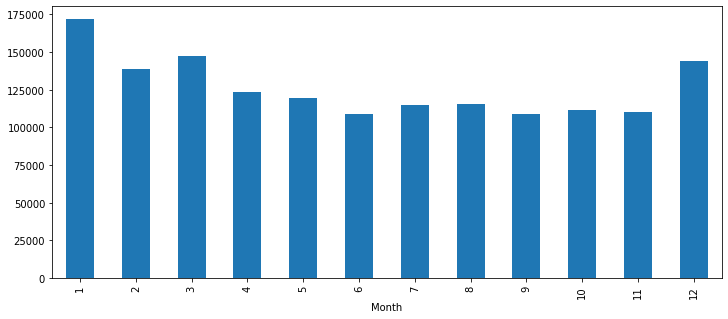

In [26]:
plt.subplots(figsize = (12,5)) 
df_musical.groupby(['Month']).size().plot(kind='bar');

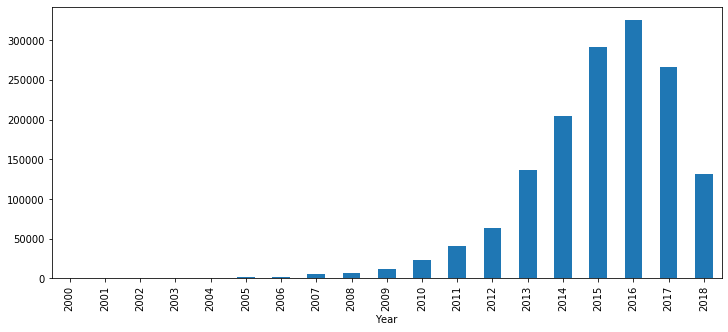

In [25]:
plt.subplots(figsize = (12,5)) 
df_musical.groupby(['Year']).size().plot(kind='bar');